#**Applied Deep Learning Individual Coursework**




### Importing all the necessary packages

In [110]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,MaxPooling1D,GlobalAveragePooling1D,AveragePooling2D,AveragePooling1D
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image
import pickle




### Loading data from the files using pickle

In [111]:
with open ('time_series_1.pickle','rb') as handle :
    time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle','rb') as handle :
    time_series_2 = pickle.load(handle)
with open ('y.pickle','rb') as handle :
    y = pickle.load(handle)

### Combining time_series_1 and time_series_2 using hstack fuction and converting y into categorical values using to_categorical function

In [112]:
# Combining the two datasets by populating a empty matrix
time_series=np.zeros(2*5000*4000).reshape(4000,5000,2)
for i in range(len(time_series_2)):
    time_series[i,0:5000,0:1]=time_series_1[i,:].reshape(5000,1)
    time_series[i,0:5000,1:5000]=time_series_2[i,:].reshape(5000,1)
# Normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#time_series = scaler.fit_transform(time_series)
y = to_categorical(y)


### Splitting the dataset so that validation and test datasets consist of 15% of the observations each

In [113]:

X_train, X_other,Y_train,Y_other = train_test_split(time_series,y, train_size=0.7,random_state = 2,stratify=y)
X_valid, X_test,Y_valid,Y_test = train_test_split(X_other,Y_other, train_size=0.5,random_state = 42,stratify=Y_other)
print(X_train.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)



(2800, 5000, 2)
(2800, 4)
(600, 4)
(600, 4)


### *Sequence-to-vector approach is observed to be most sensible here*

### **SimpleRNN Model**

In [114]:
# SimpleRNN Architecture
rnn = Sequential()
# first SimpleRNN layer
rnn.add(SimpleRNN(512,input_shape=(X_train.shape[1], 2),return_sequences=True,activation="tanh"))
rnn.add(Dropout(0.2))
# Second Layer
rnn.add(SimpleRNN(256,activation="tanh"))
rnn.add(Dropout(0.2))
# Dense layer
rnn.add(Dense(units=256,activation="tanh"))
# Output layer
rnn.add(Dense(units=4,activation="softmax"))
# Compile
rnn.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=["accuracy"])
# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
Reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "SimpleRNN.h5", save_best_only=True, monitor="val_loss")
# Fitting to the training set
history = rnn.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_valid, Y_valid),callbacks=[early_stopping_cb,Reduce,checkpoint])

Epoch 1/20
44/44 [==============================] - 422s 10s/step - loss: 1.5247 - accuracy: 0.2893 - val_loss: 1.3578 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - 420s 10s/step - loss: 1.3406 - accuracy: 0.3511 - val_loss: 1.2936 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - 420s 10s/step - loss: 1.2998 - accuracy: 0.3832 - val_loss: 1.2651 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - 417s 9s/step - loss: 1.2721 - accuracy: 0.3975 - val_loss: 1.2119 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 5/20
44/44 [==============================] - 420s 10s/step - loss: 1.2722 - accuracy: 0.4025 - val_loss: 1.2700 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 6/20
44/44 [==============================] - 420s 10s/step - loss: 1.3323 - accuracy: 0.3600 - val_loss: 1.3935 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/20
44/44 [==============================] - 415s 9s/step - loss

In [115]:
y_pred = rnn.predict(X_valid)
print("Mean square error : ",np.mean(mean_squared_error(Y_valid, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y_valid,axis=1)
print("Validation set accuracy is : ",accuracy_score(Y_true,y_pred))

Mean square error :  0.1698278
Validation set accuracy is :  0.425


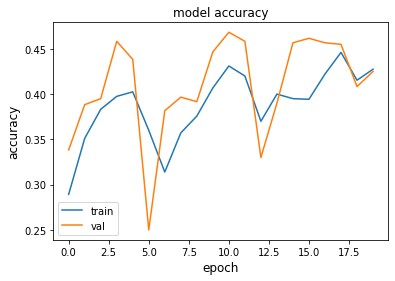

In [116]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### **LTSM Model**

In [117]:

# The LSTM architecture
ltsm = Sequential()
# First LSTM layer with Dropout regularisation
ltsm.add(LSTM(units=512,return_sequences=True,input_shape=(X_train.shape[1], 2)))
ltsm.add(Dropout(0.2))
# Second LSTM layer
ltsm.add(LSTM(units=256,return_sequences=True))
ltsm.add(Dropout(0.2))
# Third LSTM layer
ltsm.add(LSTM(units=256))
ltsm.add(Dropout(0.2))
# The output layer
ltsm.add(Dense(units=4,activation="softmax"))

# Compiling the RNN
ltsm.compile(optimizer="adam",
                  loss='categorical_crossentropy',metrics=["accuracy"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
Reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "ltsm.h5", save_best_only=True, monitor="val_loss")
# Fitting to the training set
history = ltsm.fit(X_train, Y_train, epochs=100,batch_size=64, validation_data=(X_valid, Y_valid),callbacks=[early_stopping_cb,Reduce,checkpoint])


Epoch 1/100
44/44 [==============================] - 94s 2s/step - loss: 1.4411 - accuracy: 0.2471 - val_loss: 1.3871 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 91s 2s/step - loss: 1.3920 - accuracy: 0.2393 - val_loss: 1.3915 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 90s 2s/step - loss: 1.3946 - accuracy: 0.2521 - val_loss: 1.3917 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 91s 2s/step - loss: 1.3848 - accuracy: 0.2739 - val_loss: 1.3741 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 91s 2s/step - loss: 1.3658 - accuracy: 0.3214 - val_loss: 1.3428 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 91s 2s/step - loss: 1.3218 - accuracy: 0.3593 - val_loss: 1.3033 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 91s 2s/step - loss: 1.2

In [118]:
y_pred = ltsm.predict(X_valid)
print("Mean square error : ",np.mean(mean_squared_error(Y_valid, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y_valid,axis=1)
print("Validation set accuracy is : ",accuracy_score(Y_true,y_pred))

Mean square error :  0.051633116
Validation set accuracy is :  0.8616666666666667


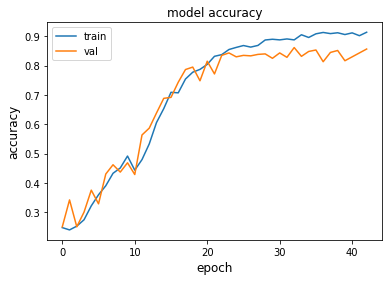

In [119]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [120]:
test_loss, test_acc = ltsm.evaluate(X_valid,Y_valid)

19/19 [==============================] - 8s 446ms/step - loss: 0.3544 - accuracy: 0.8617


### **Convolutional-1D Model** *(CNN)*

In [121]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, strides=2,
           padding="same", input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, strides=2,activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, strides=2,activation="relu"))
model.add(MaxPooling1D(2))
model.add(Flatten())
# dense layer
model.add(Dense(units=64,activation="relu"))
# dense layer
model.add(Dense(units=32,activation="relu"))
# The output layer
model.add(Dense(units=4,activation="softmax"))
# Compile
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
Reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=50, min_lr=0.00005)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "conv1d.h5", save_best_only=True, monitor="val_loss")
# Fitting to the training set
history = model.fit(X_train, Y_train, epochs=25, batch_size=32, validation_data=(X_valid, Y_valid),callbacks=[early_stopping_cb,Reduce,checkpoint])


Epoch 1/25
88/88 [==============================] - 3s 26ms/step - loss: 0.8265 - accuracy: 0.6582 - val_loss: 0.2875 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/25
88/88 [==============================] - 2s 23ms/step - loss: 0.2817 - accuracy: 0.8846 - val_loss: 0.2487 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/25
88/88 [==============================] - 2s 22ms/step - loss: 0.2945 - accuracy: 0.8707 - val_loss: 0.3075 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 4/25
88/88 [==============================] - 2s 23ms/step - loss: 0.2563 - accuracy: 0.8843 - val_loss: 0.2264 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/25
88/88 [==============================] - 2s 23ms/step - loss: 0.2599 - accuracy: 0.8807 - val_loss: 0.2888 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 6/25
88/88 [==============================] - 2s 23ms/step - loss: 0.2573 - accuracy: 0.8914 - val_loss: 0.2370 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 7/25
88/88 [==============================] - 2s 23ms/step - loss: 0.2

In [122]:
y_pred = model.predict(X_valid)
print("Mean square error : ",np.mean(mean_squared_error(Y_valid, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y_valid,axis=1)
print("Validation set accuracy is : ",accuracy_score(Y_true,y_pred))


Mean square error :  0.038399186
Validation set accuracy is :  0.8866666666666667


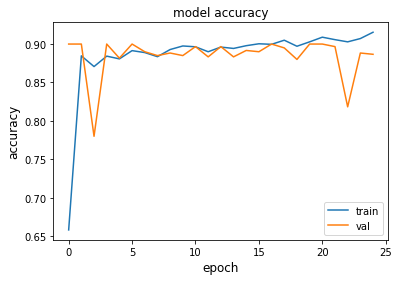

In [123]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [124]:
test_loss, test_acc = model.evaluate(X_valid,Y_valid)

19/19 [==============================] - 0s 6ms/step - loss: 0.2344 - accuracy: 0.8867


##**Analyzing time-series data using convolutional neural networks with 2D convolutional layers**

### 2.explaining why the approach outlined in the referenced paper can help analyze time-series data and why it might outperform RNNs



The approach outlined in the paper could efficiently use CNNs with time-series data to predict the operating modes better than RNNs because the recurrent neural networks have a problem of vanishing gradients when a long sequence like time series is given; hence converting the text data into images can help us train them using convolutional layers to gain better accuracy.

### 3. Converting time-series data to images to Implement CNN

In [125]:
img_data=np.zeros(100*100*4000).reshape(4000,100,100)
for i in range(4000):
    img_data[i,0:100,0:50]=time_series_1[i,:].reshape(100,50)
    img_data[i,0:100,50:100]=time_series_2[i,:].reshape(100,50)


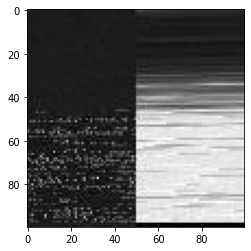

In [126]:
i = img_data[1].astype(np.uint8)
img = Image.fromarray(i, mode="L")
plt.imshow(img, cmap='gray')

In [127]:
X1_train, X1_other,Y1_train,Y1_other = train_test_split(img_data,y, train_size=0.7,stratify=y)
X1_valid, X1_test,Y1_valid,Y1_test = train_test_split(X1_other,Y1_other, train_size=0.5,stratify=Y1_other)
print(X1_train.shape)
print(Y1_train.shape)
print(Y1_valid.shape)
print(Y1_test.shape)

(2800, 100, 100)
(2800, 4)
(600, 4)
(600, 4)


### 4. Replicating the CNN with three convolutional layers as given in the referenced paper.

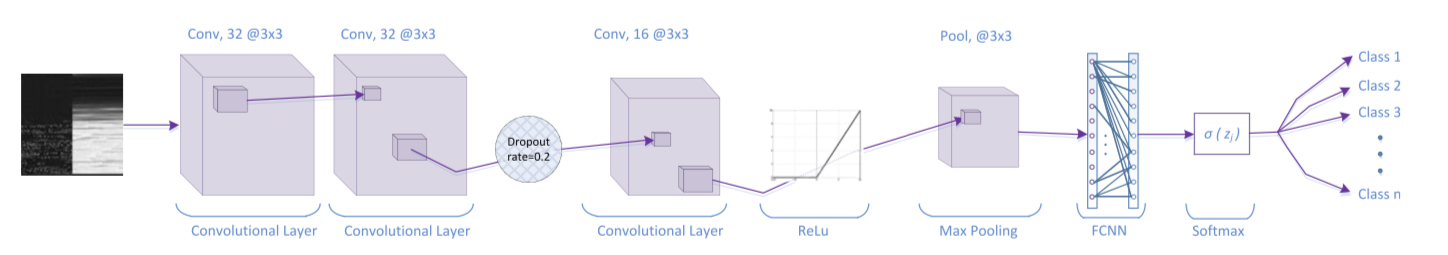

In [128]:
# Conv2D Structure
conv2d_paper = Sequential()
# Input layer
conv2d_paper.add(Conv2D(filters=32,kernel_size=3,input_shape=(100, 100, 1)))
# Second Layer
conv2d_paper.add(Conv2D(filters=32,kernel_size=3))
conv2d_paper.add(Dropout(0.2))
# Third Layer
conv2d_paper.add(Conv2D(filters=16,kernel_size=3,activation='relu'))
conv2d_paper.add(MaxPooling2D(3))
conv2d_paper.add(Flatten())
# Output Layer
conv2d_paper.add(Dense(4,activation="softmax"))
# Compile
conv2d_paper.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Fitting to the training set
history = conv2d_paper.fit(X1_train, Y1_train, epochs=25, batch_size=32, validation_data=(X1_valid, Y1_valid))

Epoch 1/25
88/88 [==============================] - 2s 23ms/step - loss: 12.1834 - accuracy: 0.2764 - val_loss: 3.6155 - val_accuracy: 0.3450
Epoch 2/25
88/88 [==============================] - 2s 21ms/step - loss: 3.9769 - accuracy: 0.4275 - val_loss: 0.7095 - val_accuracy: 0.7983
Epoch 3/25
88/88 [==============================] - 2s 21ms/step - loss: 1.9933 - accuracy: 0.6107 - val_loss: 0.5117 - val_accuracy: 0.7667
Epoch 4/25
88/88 [==============================] - 2s 21ms/step - loss: 1.3003 - accuracy: 0.7111 - val_loss: 0.5129 - val_accuracy: 0.8150
Epoch 5/25
88/88 [==============================] - 2s 21ms/step - loss: 1.0844 - accuracy: 0.7564 - val_loss: 0.3222 - val_accuracy: 0.8983
Epoch 6/25
88/88 [==============================] - 2s 21ms/step - loss: 0.8962 - accuracy: 0.7957 - val_loss: 0.2720 - val_accuracy: 0.8800
Epoch 7/25
88/88 [==============================] - 2s 21ms/step - loss: 0.9090 - accuracy: 0.8082 - val_loss: 0.3630 - val_accuracy: 0.8350
Epoch 8/25
8

In [129]:
y_pred = conv2d_paper.predict(X1_valid)
print("Mean square error : ",np.mean(mean_squared_error(Y1_valid, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y1_valid,axis=1)
print("Validation set accuracy is : ",accuracy_score(Y_true,y_pred))

Mean square error :  0.03326226
Validation set accuracy is :  0.895


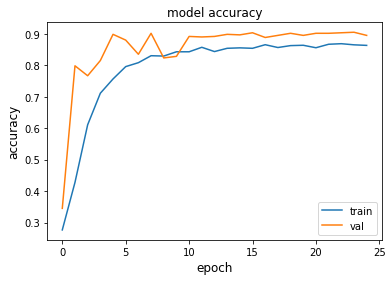

In [130]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [131]:
test_loss, test_acc = conv2d_paper.evaluate(X1_valid,Y1_valid)

19/19 [==============================] - 0s 8ms/step - loss: 0.2116 - accuracy: 0.8950


### 5. Tuning CNN

In [177]:
# Conv2D Structure
conv2d = Sequential()
# Input layer
conv2d.add(Conv2D(filters=32,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same",input_shape=(100, 100, 1)))
# First Layer
conv2d.add(Conv2D(filters=32,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same"))
conv2d.add(MaxPooling2D(3))
# Second Layer
conv2d.add(Conv2D(filters=64,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same"))
conv2d.add(Dropout(0.25))
#third layer
conv2d.add(Conv2D(filters=64,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same"))
conv2d.add(MaxPooling2D(3))
# fourth Layer
conv2d.add(Conv2D(filters=128,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same"))
conv2d.add(Dropout(0.25))
# fifth Layer
conv2d.add(Conv2D(filters=128,dilation_rate=2,kernel_size=3,strides=1,activation='relu',padding="same"))
conv2d.add(MaxPooling2D(3))
conv2d.add(Flatten())
# Dense Layers
conv2d.add(Dense(64,activation="relu"))
# Output Layer
conv2d.add(Dense(4,activation="softmax"))
# Compile
conv2d.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=11, restore_best_weights=True)
Reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00005)
# Fitting to the training set
history = conv2d.fit(X1_train, Y1_train, epochs=25, batch_size=64, validation_data=(X1_valid, Y1_valid),callbacks=[early_stopping_cb,Reduce])




Epoch 1/25
44/44 [==============================] - 4s 72ms/step - loss: 2.4635 - accuracy: 0.2489 - val_loss: 1.3790 - val_accuracy: 0.2850 - lr: 0.0010
Epoch 2/25
44/44 [==============================] - 3s 66ms/step - loss: 1.3823 - accuracy: 0.2829 - val_loss: 1.3711 - val_accuracy: 0.2517 - lr: 0.0010
Epoch 3/25
44/44 [==============================] - 3s 66ms/step - loss: 1.2482 - accuracy: 0.4325 - val_loss: 0.9659 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 4/25
44/44 [==============================] - 3s 66ms/step - loss: 0.7181 - accuracy: 0.7279 - val_loss: 0.4136 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/25
44/44 [==============================] - 3s 66ms/step - loss: 0.3455 - accuracy: 0.8789 - val_loss: 0.2142 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 6/25
44/44 [==============================] - 3s 66ms/step - loss: 0.2837 - accuracy: 0.8882 - val_loss: 0.2475 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 7/25
44/44 [==============================] - 3s 66ms/step - loss: 0.2

In [178]:
y_pred = conv2d.predict(X1_valid)
print("Mean square error : ",np.mean(mean_squared_error(Y1_valid, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y1_valid,axis=1)
print("Validation set accuracy is : ",accuracy_score(Y_true,y_pred))

Mean square error :  0.03364009
Validation set accuracy is :  0.9083333333333333


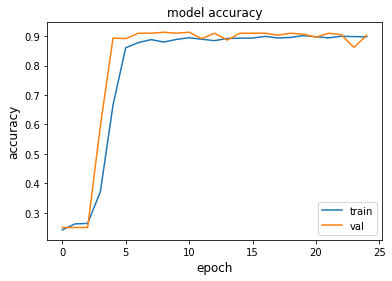

In [167]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [168]:
test_loss, test_acc = conv2d.evaluate(X1_valid,Y1_valid)

19/19 [==============================] - 1s 26ms/step - loss: 0.2199 - accuracy: 0.9033


### 6. Comparing all models and arriving at a preferred model to use

The SimpleRNN seems to achieve an validation set accuracy of 42.5%, and when an LTSM network that already has tanh and sigmoid activation functions internally, it gives us an accuracy of 87%; however, the accuracy is increased to 90% when Relu is used as activation function, but LTSM flattens out some timesteps instead of showing the natural variation in time steps, which means it might not fit the data appropriately as it appears to diverge.

Whereas the 3-layer CNN, which has been replicated from the referenced paper, gives an accuracy of 89% on the validation set, and the tuned model provides an accuracy of 91% on the validation set, we choose the tuned CNN Model to evaluate it on the test set.

In [136]:
X_train, X_test,Y_train,Y_test = train_test_split(img_data,y, train_size=0.85,stratify=y)

In [179]:
conv2d.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
conv2d.save("Tuned_CNN_Model_Task_6.h5")

In [145]:
# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=11, restore_best_weights=True)
Reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00005)
# Fitting to the training set
history = conv2d.fit(X_train, Y_train, epochs=25, batch_size=64,callbacks=[early_stopping_cb,Reduce])

Epoch 1/25
54/54 [==============================] - 4s 57ms/step - loss: 0.2252 - accuracy: 0.8997 - lr: 1.0000e-04
Epoch 2/25
54/54 [==============================] - 3s 56ms/step - loss: 0.2192 - accuracy: 0.8974 - lr: 1.0000e-04
Epoch 3/25
54/54 [==============================] - 3s 56ms/step - loss: 0.2183 - accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/25
54/54 [==============================] - 3s 56ms/step - loss: 0.2174 - accuracy: 0.9038 - lr: 1.0000e-04
Epoch 5/25
54/54 [==============================] - 3s 57ms/step - loss: 0.2169 - accuracy: 0.9000 - lr: 1.0000e-04
Epoch 6/25
54/54 [==============================] - 3s 57ms/step - loss: 0.2236 - accuracy: 0.9009 - lr: 1.0000e-04
Epoch 7/25
54/54 [==============================] - 3s 57ms/step - loss: 0.2120 - accuracy: 0.9035 - lr: 1.0000e-04
Epoch 8/25
54/54 [==============================] - 3s 58ms/step - loss: 0.2142 - accuracy: 0.9018 - lr: 1.0000e-04
Epoch 9/25
54/54 [==============================] - 3s 60ms/step - loss:

In [146]:
test_loss, test_acc = conv2d.evaluate(X_test,Y_test)

19/19 [==============================] - 0s 16ms/step - loss: 0.2512 - accuracy: 0.8867


In [147]:
y_pred = conv2d.predict(X_test)
print("Mean square error : ",np.mean(mean_squared_error(Y_test, y_pred)))
y_pred = np.argmax(y_pred,axis=1)
Y_true = np.argmax(Y_test,axis=1)
print("Test set accuracy is : ",accuracy_score(Y_true,y_pred))


Mean square error :  0.039280657
Test set accuracy is :  0.8866666666666667
